# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Agent Service

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
import os

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

The following cell will **create the Azure AI Agents**, so you only need to run this cell **once**.

In [3]:
# from common.create_azure_ai_agents import (
#     create_bing_search_agent,
#     create_research_plan_agent,
#     create_summary_agent,
#     create_research_report_agent,
#     create_peer_review_agent
# )

# planner_agent = create_research_plan_agent(project_client=project_client)
# bing_search_agent = create_bing_search_agent(project_client=project_client)
# summary_agent = create_summary_agent(project_client=project_client)
# research_agent = create_research_report_agent(project_client=project_client)
# peer_review_agent = create_peer_review_agent(project_client=project_client)

Fetch agents from your AI Foundry Project

In [4]:
planner_agent = project_client.agents.get_agent(agent_id=os.getenv("PlannerAgentID"))
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("BingSearchAgentID"))
summary_agent = project_client.agents.get_agent(agent_id=os.getenv("SummaryAgentID"))
research_agent = project_client.agents.get_agent(agent_id=os.getenv("ResearchAgentID"))
peer_review_agent = project_client.agents.get_agent(agent_id=os.getenv("PeerReviewAgentID"))

Update their system messages

In [5]:
from common.update_instructions import (
    update_planner_instructions,
    update_bing_instructions,
    update_summary_instructions,
    update_research_instructions,
    update_peer_review_instructions
)

planner_agent = update_planner_instructions(agent=planner_agent)
bing_search_agent = update_bing_instructions(agent=bing_search_agent)
summary_agent = update_summary_instructions(agent=summary_agent)
research_agent = update_research_instructions(agent=research_agent)
peer_review_agent = update_peer_review_instructions(agent=peer_review_agent)

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

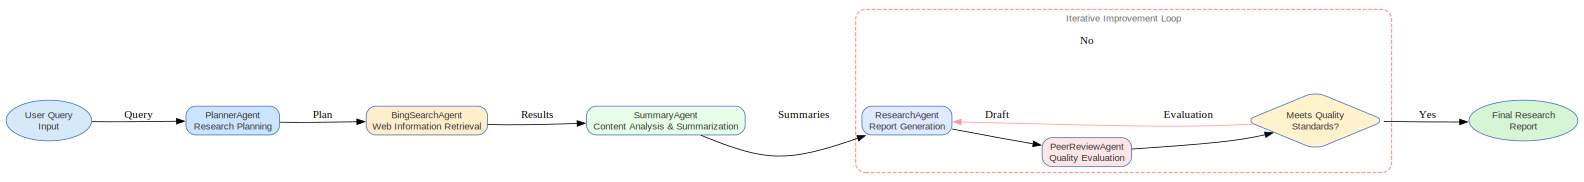

In [6]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [7]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [8]:
from azure.ai.agents.models import MessageRole
from common.data_models import ResearchPlan
from common.utils_ai_agents import (
    add_user_message_to_thread,
    invoke_agent
)
import json

# create a thread and add the user message
thread = project_client.agents.threads.create()
add_user_message_to_thread(project_client, thread.id, user_query)

# invoke the planner agent to create a research plan
planner_agent_output, thread = invoke_agent(
    project_client=project_client,
    thread=thread,
    agent=planner_agent
)

# parse the output to a ResearchPlan object
plan_data = json.loads(planner_agent_output)
plan = ResearchPlan(**plan_data)

# delete the thread
project_client.agents.threads.delete(thread_id=thread.id)

In [9]:
plan.research_tasks[0].search_queries

['What is classical machine learning?',
 'Definition of deep learning in AI',
 'What is generative AI?',
 'Overview of classical machine learning vs deep learning vs generative AI',
 'Key characteristics of classical ML, deep learning, and generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [10]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            add_user_message_to_thread(project_client, thread.id, formatted_query)

            bing_search_agent_output, thread = invoke_agent(
                project_client=project_client,
                thread=thread,
                agent=bing_search_agent
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [03:55<00:00, 47.06s/it]


In [11]:
print(f"Planned total search queries: {sum(1 for task in plan.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 25

Actually total search queries: 25



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [12]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            thread = project_client.agents.threads.create()
            add_user_message_to_thread(project_client, thread.id, summary_prompt)
            # Invoke the summary agent to summarize the content
            summary_agent_output, thread = invoke_agent(
                project_client=project_client,
                thread=thread,
                agent=summary_agent
            )

            # run = project_client.agents.runs.create_and_process(thread_id=thread.id, agent_id=summary_agent.id)
            # subtopic_summary = get_last_message_by_role(project_client, thread.id, MessageRole.AGENT)
            subtopic_summary = summary_agent_output.strip()  # Ensure we get the text output
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 5/5 [01:36<00:00, 19.21s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [58]:
def print_thread_messages(thread):
    messages = project_client.agents.messages.list(thread_id=thread.id)
    for m in messages:
        print(f"roll: {m.role}")
        print(f"agent_id: {m.agent_id}")
        print(f"content: {m.content[0]['text']['value']}")
        print("---")

In [63]:
from common.data_models import ComprehensiveResearchReport, PeerReviewFeedback
from common.utils_ai_agents import add_user_message_to_thread

def loop_agents(project_client, agent_a, agent_b, initial_input, max_iterations=10):
    """
    Loop between two agents until agent B produces the target output.
    
    Args:
        agent_a: Function that takes input and returns output
        agent_b: Function that takes input and returns output
        initial_input: Starting input for agent A
        max_iterations: Safety limit to prevent infinite loops
    
    Returns:
        The final output from agent B, or None if max iterations reached
    """
    current_input = initial_input
    thread = project_client.agents.threads.create()
    add_user_message_to_thread(project_client, thread.id, current_input)

    for i in range(max_iterations):
        # Agent A processes the input and produces output
        a_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_a
        )

        handover_message = f"A research agent has produced a research report. Please review it."
        add_user_message_to_thread(project_client, thread.id, handover_message)
        
        # Agent B reviews the output
        b_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_b
        )

        b_output_json = json.loads(b_output)
        review = PeerReviewFeedback(**b_output_json)

        # Check if B produced the target output
        if review.is_satisfactory is not False:
            print(f"Target output reached after {i+1} iterations!")
            report_json = json.loads(a_output)
            final_report = ComprehensiveResearchReport(**report_json)

            # delete the thread
            # print_thread_messages(thread)
            project_client.agents.threads.delete(thread_id=thread.id)
            return final_report
        
        # Use B's output as input for the next iteration
        current_input = b_output
        
        handover_message = f"Peer review agent has provided feedback. Please revise the research report based on the feedback."
        add_user_message_to_thread(project_client, thread.id, handover_message)

    # delete the thread
    # print_thread_messages(thread)
    project_client.agents.threads.delete(thread_id=thread.id)
    print(f"Max iterations ({max_iterations}) reached without finding target output")

    return None

In [64]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

research_query = (
    "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
    "using the following content. **Minimize bullet points** and ensure the final text resembles "
    "a cohesive, academic-style paper:\n\n"
    f"{research_input_prompt}\n\n"
    "As a final reminder, don't forget to include the citation list at the end of the report."
)

# Run the loop
final_report = loop_agents(
    project_client=project_client,
    agent_a=research_agent,
    agent_b=peer_review_agent,
    initial_input=research_query,
    max_iterations=10
)

Target output reached after 1 iterations!



In [65]:
from IPython.display import display, Markdown
display(Markdown(final_report.research_report))

# The Evolution and Distinction of Classical Machine Learning, Deep Learning, and Generative AI: Definitions, Methodologies, Applications, and Implications

## Introduction

The field of artificial intelligence (AI) has undergone a profound transformation over the past several decades, evolving from rule-based symbolic systems to sophisticated, data-driven models capable of perception, reasoning, and creative generation. At the heart of this evolution are three major paradigms: classical machine learning, deep learning, and generative AI. Each represents a distinct approach to modeling, learning, and problem-solving, shaped by advances in theory, computational power, and the ever-increasing availability of data. This report aims to provide a comprehensive, nuanced, and authoritative analysis of these paradigms, elucidating their definitions, methodologies, real-world applications, strengths, limitations, and historical trajectories. Through a detailed comparative exploration, we seek to clarify not only how these approaches differ but also how they collectively underpin the expanding landscape of intelligent systems and automation in society.

## Definitions and Core Concepts

A clear understanding of the foundational concepts behind classical machine learning, deep learning, and generative AI is essential for appreciating their respective methodologies and applications. While these domains are interrelated, each is defined by unique principles, data requirements, and operational goals.

### Classical Machine Learning

Classical machine learning encompasses a suite of statistical algorithms designed primarily for the analysis of structured data—datasets organized in tabular form, with well-defined features and labels. The core premise of classical ML is to learn patterns or relationships from data to make predictions or uncover hidden structures. This is achieved through two primary paradigms: supervised learning, where models are trained on labeled data to predict outcomes (e.g., regression, classification), and unsupervised learning, where models seek to identify clusters or latent structures without explicit labels (e.g., clustering, dimensionality reduction).

A defining characteristic of classical ML is the reliance on feature engineering. Here, domain experts manually select, transform, or construct input variables to optimize model performance. This process injects human insight directly into the modeling pipeline, enhancing interpretability but often limiting scalability to complex or high-dimensional data. Classical algorithms such as support vector machines (SVM), decision trees, linear and logistic regression, k-nearest neighbors (KNN), and ensemble methods like random forests and gradient boosting remain foundational in business, healthcare, and finance due to their transparency and computational efficiency [1][2].

### Deep Learning

Deep learning, a transformative subset of machine learning, leverages artificial neural networks with multiple layers—hence the term "deep"—to learn directly from raw, often unstructured, data. Unlike classical ML, deep learning models are capable of automatic feature extraction, identifying hierarchical representations of data without explicit human intervention. This enables these models to excel in domains characterized by high-dimensional, complex, and unstructured data, such as images, audio, and natural language text.

Key architectures within deep learning include convolutional neural networks (CNNs) for spatial data (e.g., images), recurrent neural networks (RNNs) and their variants (LSTMs, GRUs) for sequential data (e.g., speech, time series), and transformers for tasks requiring long-range context and parallel processing (e.g., language modeling, translation). Deep learning's capacity to scale with data and computational resources has driven breakthroughs in perception, automation, and natural language understanding, albeit at the cost of interpretability and resource intensity [3][4].

### Generative AI

Generative AI represents a specialized domain within artificial intelligence focused on the creation of new, original content. Rather than merely predicting labels or extracting information, generative AI models synthesize novel outputs—text, images, audio, code—by learning the underlying structure and distribution of their training data. This is achieved through advanced generative models such as generative adversarial networks (GANs), variational autoencoders (VAEs), diffusion models, and large language models (LLMs) like GPT.

A hallmark of generative AI is its prompt-based interaction, where users provide instructions or context and the model generates relevant content in response. Applications span text and image synthesis, code generation, creative design, and more. Generative AI systems are notable for their adaptability, often allowing fine-tuning for domain-specific tasks and enabling the automation of creative and professional content generation [5][6].

### Comparative Overview

To crystallize the distinctions among these paradigms, the following table summarizes key aspects:

| Aspect                | Classical ML          | Deep Learning                | Generative AI                  |
|-----------------------|----------------------|------------------------------|-------------------------------|
| Data type             | Structured           | Unstructured (and structured)| Unstructured (mostly)         |
| Feature Engineering   | Manual               | Automatic (representation)   | Automatic (representation)    |
| Model Complexity      | Lower                | High (many layers)           | Very high (large models)      |
| Output                | Predictions/Labels   | Predictions/Labels           | New content/data              |
| Example Algorithms    | SVM, Decision Trees  | CNN, RNN, Transformers       | GANs, VAEs, LLMs              |

While deep learning and generative AI share a foundation in neural networks and automated representation learning, generative AI distinguishes itself through its creative capacity, producing original content beyond traditional prediction tasks. Classical machine learning, meanwhile, remains a mainstay for structured data analysis, prized for its interpretability and efficiency [1][3][5].

## Methodologies and Architectures

The methodologies and architectural choices underlying classical machine learning, deep learning, and generative AI reflect the increasing complexity and ambition of modern AI systems. Each paradigm is optimized for particular data types, computational constraints, and application domains, with trade-offs in interpretability, scalability, and generative capacity.

### Classical Machine Learning Methodologies and Architectures

Classical ML is grounded in a diverse set of algorithmic techniques, each tailored to specific tasks and data structures. Supervised learning algorithms include linear regression (for continuous value prediction), logistic regression (for binary classification), decision trees (for recursive partitioning), SVMs (for optimal class separation), and ensemble methods like random forests and gradient boosting (for improved accuracy and robustness). Unsupervised learning encompasses k-means clustering (for grouping similar data points), principal component analysis (for dimensionality reduction), and hierarchical clustering.

A defining methodological feature is the explicit, domain-driven feature engineering process. Practitioners must carefully select and transform input variables to capture relevant patterns, often relying on statistical intuition and domain expertise. Model evaluation employs metrics such as accuracy, precision, recall, and cross-validation to ensure generalizability and guard against overfitting. Classical ML models are typically computationally efficient, interpretable, and well-suited for small to medium-sized structured datasets, but their performance degrades on unstructured or high-dimensional data [2][7].

### Deep Learning Architectures and Methodologies

Deep learning introduces a paradigm shift by enabling models to learn complex, hierarchical representations directly from raw data. The most prominent architectures include:

- **Convolutional Neural Networks (CNNs):** Designed for spatial data, CNNs use convolutional and pooling layers to extract local and global features from images, excelling in image classification, object detection, and segmentation.
- **Recurrent Neural Networks (RNNs):** Tailored for sequential data, RNNs (and their variants LSTMs and GRUs) capture temporal dependencies, making them ideal for language modeling, speech recognition, and time-series analysis.
- **Transformers:** Revolutionizing natural language processing, transformers employ self-attention mechanisms to model long-range dependencies and enable parallel processing. Architectures like BERT and GPT have set new benchmarks in translation, summarization, and code generation.
- **Autoencoders:** Encoder-decoder pairs for unsupervised representation learning, supporting dimensionality reduction and anomaly detection.

Deep learning models are data-hungry, requiring large labeled datasets and significant computational resources (often GPUs or TPUs) for training. They excel in extracting features from unstructured data, automating tasks that previously required manual intervention. However, their complexity introduces challenges in interpretability, training stability, and energy consumption [3][4][8].

### Generative AI Methodologies and Architectural Innovations

Generative AI builds upon deep learning foundations, introducing architectures specifically designed for content creation:

- **Generative Adversarial Networks (GANs):** Comprising a generator and discriminator in adversarial training, GANs produce synthetic data that closely matches the distribution of real data, enabling realistic image and data generation.
- **Variational Autoencoders (VAEs):** Probabilistic models that encode data into a latent space and decode it to generate new samples, supporting anomaly detection and novel content creation.
- **Diffusion Models:** Learn to denoise data progressively, transforming random noise into coherent outputs, achieving high fidelity in synthetic image and audio generation.
- **Transformer-based Large Language Models (LLMs):** Models like GPT and BERT, with billions of parameters, generate high-quality text, code, and multimodal content, leveraging self-supervised learning and vast pretraining corpora.

Generative AI models often employ self-supervised or unsupervised objectives, reducing the need for labeled data and enabling transfer learning and few-shot adaptation. Recent trends include multimodal architectures capable of integrating text, image, and audio inputs/outputs, and agentic retrieval systems that combine LLMs with search and embedding retrieval for richer, context-aware responses [5][7][9].

### Comparative Context: Methodological and Architectural Trade-offs

The progression from classical ML to deep learning and generative AI is marked by increasing abstraction in data representation, model complexity, and computational demand. Classical ML is optimal for structured, interpretable, and resource-efficient applications; deep learning unlocks automatic feature discovery for complex, unstructured data; and generative AI pushes the frontier of content creation, requiring even greater resources and raising new challenges in evaluation, bias, and control [2][7][10].

## Applications and Use Cases

The practical impact of classical machine learning, deep learning, and generative AI is evident across a wide array of industries and domains. Each paradigm addresses distinct challenges, shaped by data structure, interpretability requirements, and the desired outcome—prediction, recognition, or generation.

### Classical Machine Learning Applications

Classical ML remains indispensable in scenarios involving structured or tabular data and where transparency is paramount. In healthcare, algorithms like SVMs and logistic regression are used for disease diagnosis, risk prediction, and patient stratification, while decision trees and KNN assist in medical image analysis and tumor detection. In finance, linear regression and decision trees underpin credit scoring models, fraud detection, and risk assessment, providing clear justifications for decisions—a necessity in regulated environments. Retail and marketing leverage clustering and regression for customer segmentation, targeted campaigns, and sales forecasting. Manufacturing applies classical ML for predictive maintenance and quality control, using sensor and inspection data to anticipate equipment failures and ensure product standards. Transportation systems utilize KNN for route optimization and regression for traffic forecasting. Text and speech processing applications include spam detection and sentiment analysis, essential for communication moderation and consumer feedback analysis. The interpretability and efficiency of classical ML make it the preferred choice in high-trust, operationally sensitive domains [11][12].

### Deep Learning Applications

Deep learning has enabled breakthroughs in domains characterized by massive, unstructured datasets and complex, nonlinear relationships. In healthcare, deep learning models analyze imaging data (X-rays, MRIs, CT scans) with accuracy rivaling or surpassing human experts, as demonstrated by DeepMind's AI for eye disease detection. Pharmaceutical research employs deep learning for drug discovery, modeling molecular interactions, and predicting new compounds. Finance benefits from deep learning in fraud detection, algorithmic trading, and advanced credit assessments, ingesting diverse, high-dimensional data. Retail and e-commerce platforms deploy deep networks for real-time recommendations, visual search, and dynamic inventory management. Autonomous vehicles rely on deep learning for perception, object and lane detection, and adaptive traffic forecasting. Manufacturing uses deep models for predictive maintenance and quality assurance via sophisticated visual inspections. Security applications include facial recognition and anomaly detection, enhancing both physical and cyber defenses. The capacity of deep learning to discern intricate patterns underpins advances in voice recognition, natural language processing, and autonomous system control [13][14][15].

### Generative AI Applications

Generative AI represents the latest leap in AI-driven innovation, characterized by models capable of producing novel content across modalities. As of 2024, adoption has surged in both consumer and enterprise settings, powered by transformer-based architectures like GPT-4, DALL-E, and Midjourney. In content creation and marketing, generative AI automates ideation, drafting, and production of copy, social posts, articles, and video assets, scaling personalization and creativity. Search engines have integrated generative components to facilitate conversational, interactive queries, presenting users with AI-organized, contextually rich results. Software engineering benefits from tools that auto-generate code, conduct real-time debugging, and create technical documentation, boosting developer productivity. Customer service has been transformed by advanced chatbots and virtual assistants, resolving a growing proportion of inquiries and offering 24/7 support. The creative sector leverages generative tools for graphic design, video editing, and music composition, empowering rapid iteration and experimentation. Healthcare applications include generating candidate molecular structures for drug discovery and producing synthetic medical data for improved modeling. Finance utilizes generative AI for scenario analysis, risk management, and compliance report generation. Education and corporate training employ AI-powered personalized tutoring and content creation to enhance engagement and learning outcomes. Analysts estimate that generative AI could add up to $4.4 trillion annually across major business use cases, signaling a profound macroeconomic impact [16][17][18].

### Comparative Analysis of Sector-Specific Alignment

The alignment of each paradigm with industry needs is shaped by the nature of the data, the requirement for explainability, and the complexity or creativity of the task. Classical ML is ideal for high-trust environments with structured inputs and regulatory demands for transparency. Deep learning opens opportunities in perception, automation, and inference from high-dimensional, complex data. Generative AI bridges prediction and creativity, enabling entirely new products and interactive experiences. Increasingly, hybrid systems and problem-specific tailoring blur the boundaries, offering a spectrum of solutions to match operational constraints, innovation goals, and data realities [12][14][17].

## Strengths and Limitations

A nuanced understanding of the strengths and limitations of classical machine learning, deep learning, and generative AI is essential for informed model selection, risk management, and responsible deployment.

### Classical Machine Learning

Classical ML algorithms are celebrated for their interpretability, computational efficiency, and reliability on smaller datasets. Their mathematical transparency allows practitioners to trace and rationalize decision-making, making them suitable for domains where explainability is critical. Fast training times and modest hardware requirements facilitate rapid prototyping and iterative development. However, classical ML struggles with complex or high-dimensional data, especially where relationships are nonlinear or the data is unstructured. Manual feature engineering is often required, necessitating domain expertise and extra development time. Scalability is a challenge for instance-based methods as datasets grow, and models require explicit retraining to adapt to new data distributions [19][20].

### Deep Learning

Deep learning offers transformative advantages in environments with large volumes of unstructured data. Its ability to learn hierarchical representations from raw data underlies its dominant performance in image recognition, natural language processing, and speech-to-text applications. Model performance often improves with increased data and computational resources, pushing the boundaries of AI capabilities. However, deep learning is resource- and time-intensive, requiring specialized hardware and massive labeled datasets. Interpretability is low, with complex internal representations making it difficult to trace decisions or ensure compliance. Overfitting is a risk if models are not properly regularized, and transfer to new tasks often demands considerable retraining [21][22][23].

### Generative AI

Generative AI models excel in automatic content creation, fueling innovation in chatbots, content synthesis, simulation, and creative industries. Advances in architectures and pre-training have introduced transfer and few-shot learning, reducing data needs for adaptation. However, generative AI faces critical obstacles. Outputs can perpetuate or amplify biases in training data, raising ethical and fairness concerns. The phenomenon of "hallucination"—generating plausible but incorrect outputs—limits reliability in high-stakes contexts. Generative models may struggle with rare, novel, or nuanced situations and pose risks related to data privacy. Resource demands are extreme, with high computational and energy costs. Interpretability and controllability are low, and the ability to synthesize convincing content opens avenues for misuse, necessitating rigorous monitoring and safeguards [24][25][26].

### Cross-Cutting Challenges

Across all paradigms, challenges persist regarding data quality, model interpretability, and generalization. Biased, incomplete, or noisy datasets can propagate errors and unfairness. As model complexity increases, interpretability decreases, posing compliance hurdles and eroding trust. Generalization—the ability to perform well on unseen data—remains the defining test of robustness, requiring sophisticated validation and ongoing monitoring. The choice of approach hinges on use case specifics, available resources, interpretability requirements, and the nature of the input data [19][21][24].

## Historical and Technological Evolution

The evolution of artificial intelligence and machine learning is marked by a series of transformative phases, each catalyzed by breakthroughs in theory, methodology, and application. Understanding this trajectory provides critical context for the current state and future direction of AI.

### Foundational Decades (1940s–1970s)

AI's genesis can be traced to Alan Turing's pioneering work in the 1950s, including the Turing Test, which posed foundational questions about machine intelligence. The Dartmouth Conference in 1956 officially inaugurated the field. Early decades focused on symbolic reasoning, pattern recognition, and computational learning theory. Frank Rosenblatt's 1957 invention of the perceptron—a simple neural network—demonstrated machine learning from data. However, early neural networks were limited to linearly separable problems, leading to a focus on rule-based and expert systems [27][28].

### Statistical Machine Learning and Neural Resurgence (1970s–1990s)

The 1970s and 1980s saw a shift toward statistical methods, including decision trees and ensemble methodologies. The backpropagation algorithm, popularized in 1986, enabled the training of multi-layer neural networks, reigniting interest in connectionist approaches. The 1990s brought powerful tools like SVMs, random forests, and boosting, which improved predictive performance on structured data, albeit requiring extensive feature engineering [29][30].

### Data-Driven Approaches and Practical Applications (2000s)

The 2000s witnessed a surge in practical ML applications, propelled by increased computing power and large-scale digital datasets. Techniques such as k-means clustering, principal component analysis, and naive Bayes became standard tools across finance, healthcare, and marketing. Kernel methods and robust ensemble strategies gained traction, while advances in parallel computation and GPU hardware further boosted performance [31].

### Deep Learning Revolution (2010s)

A crucial inflection point occurred in 2006 with the introduction of unsupervised pre-training for deep architectures. The 2012 victory of AlexNet—a deep CNN—in the ImageNet competition marked the ascendancy of deep learning, showcasing its superiority in image recognition. Deep learning models automated the extraction of hierarchical features from unstructured data, scaling effectively with data and unlocking capabilities in computer vision, speech recognition, and NLP [32][33].

### Generative AI and Foundation Models (Late 2010s–Present)

The emergence of generative AI marks the latest chapter in AI's evolution. Generative models such as GANs (introduced in 2014), transformers, and LLMs like BERT (2018) and GPT-3 (2020) have become foundational, capable of ingesting massive datasets, understanding context, and producing novel content at superhuman fluency and scale. Foundation models, trained on diverse corpora, serve as general-purpose engines adaptable to myriad tasks. The implementation of agentic retrieval and semantic search in enterprise environments and major search platforms illustrates how generative AI is transforming user experiences and information retrieval [34][35][36].

### Broader Impact and Nuances

Each technological leap has been enabled by advances in hardware (notably GPUs and distributed cloud infrastructure) and the exponential growth in digital data. Classical ML remains relevant for applications demanding interpretability and efficiency, while deep learning and generative AI dominate tasks involving unstructured or multimodal data. The present era, characterized by generative AI and foundation models, signals unprecedented potential and new challenges as the field continues its rapid trajectory [27][32][34].

### Timeline of Major Developments

| Year | Milestone                                             |
|------|-------------------------------------------------------|
| 1950 | Turing Test proposed                                  |
| 1957 | Perceptron invented                                   |
| 1967 | Nearest Neighbor algorithm introduced                 |
| 1986 | Backpropagation popularized                           |
| 1995 | Support Vector Machines (SVMs) developed              |
| 2006 | Unsupervised pre-training for deep architectures      |
| 2012 | AlexNet wins ImageNet (deep learning breakthrough)    |
| 2014 | Generative Adversarial Networks (GANs) introduced     |
| 2018 | BERT (transformer-based LLM) released                 |
| 2020 | GPT-3 (large-scale generative language model) launched|
| 2024 | Widespread adoption of generative AI in industry      |

## Synthesis and Future Directions

The distinctions among classical machine learning, deep learning, and generative AI are both clear and consequential. Classical ML offers interpretability and efficiency for structured data, deep learning unlocks automatic feature discovery and excels in unstructured domains, and generative AI enables unprecedented content creation and automation. Each paradigm is shaped by its methodological foundations, data requirements, and application domains, with strengths and limitations that inform responsible deployment.

The historical evolution from rule-based systems to generative models reflects a continual move toward automation, adaptability, and generalization. As AI systems become more autonomous and context-aware, new challenges arise—ranging from ethical risk and bias to interpretability and sustainability. The future of AI will likely be defined by hybrid approaches, integrating the strengths of each paradigm, and by advances in governance, transparency, and human-AI collaboration.

In conclusion, a comprehensive understanding of these paradigms is essential for navigating the rapidly evolving AI landscape, enabling informed decision-making, responsible innovation, and the realization of AI's transformative potential across society and industry.

## References

[1] What is Generative AI? - IBM, https://www.ibm.com/think/topics/generative-ai  
[2] AI explained: What is generative AI? | Article | Visma, https://www.visma.com/resources/content/ai-explained-what-is-generative-ai  
[3] Deep Learning Definition | DeepAI, https://deepai.org/machine-learning-glossary-and-terms/deep-learning  
[4] What Is Deep Learning? - IBM, https://www.ibm.com/think/topics/deep-learning  
[5] What Is Generative AI? Definition, Applications, and Impact, https://www.coursera.org/articles/what-is-generative-ai  
[6] Generative artificial intelligence - Wikipedia, https://en.wikipedia.org/wiki/Generative_artificial_intelligence  
[7] The Evolution of AI Architecture: From Traditional Machine Learning to ..., https://aimresearch.co/generative-ai/the-evolution-of-ai-architecture-from-traditional-machine-learning-to-generative-ai  
[8] Transformer (deep learning architecture) - Wikipedia, https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)  
[9] Modern AI: GenAI vs Machine Learning vs Deep Learning vs LLMs - Cloud4C, https://www.cloud4c.com/blogs/genai-vs-machine-learning-vs-deep-learning-vs-llms  
[10] Generative AI vs Traditional AI - GeeksforGeeks, https://www.geeksforgeeks.org/difference-between-generative-ai-and-traditional-ai/  
[11] Top 20 Deep Learning Case Studies [Detailed Analysis] [2025], https://digitaldefynd.com/IQ/deep-learning-case-studies/  
[12] 20 Deep Learning Applications in 2024 Across Industries, https://www.pickl.ai/blog/deep-learning-applications/  
[13] Top 41 Deep Learning Use Cases & Examples in 2025 - Expertbeacon, https://expertbeacon.com/deep-learning-applications/  
[14] Introducing agentic retrieval in Azure AI Search: an automated query ..., https://techcommunity.microsoft.com/blog/azure-ai-services-blog/introducing-agentic-retrieval-in-azure-ai-search/4414677  
[15] Google I/O 2024: New generative AI experiences in Search, https://blog.google/products/search/generative-ai-google-search-may-2024/  
[16] Generative AI Trends And Use Cases To Follow In 2024 - Forbes, https://www.forbes.com/councils/forbestechcouncil/2024/02/21/generative-ai-trends-and-use-cases-to-follow-in-2024/  
[17] Trends defining generative AI in 2024 - Implement, https://implementconsultinggroup.com/article/eight-trends-of-generative-ai-2024  
[18] The state of AI in early 2024: Gen AI adoption spikes and starts to ..., https://www.mckinsey.com/~/media/mckinsey/business%20functions/quantumblack/our%20insights/the%20state%20of%20ai/2024/the-state-of-ai-in-early-2024-final.pdf  
[19] Challenges in Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/challenges-in-deep-learning/  
[20] Advantages and Disadvantages of Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/advantages-and-disadvantages-of-deep-learning/  
[21] Deep learning: systematic review, models, challenges, and research ..., https://link.springer.com/article/10.1007/s00521-023-08957-4  
[22] Review of deep learning: concepts, CNN architectures, challenges ..., https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00444-8  
[23] A Survey on State-of-the-art Deep Learning Applications and Challenges, https://arxiv.org/abs/2403.17561  
[24] Semrush Report: AI Overviews’ Impact on Search in 2025, https://www.semrush.com/blog/semrush-ai-overviews-study/  
[25] Agentic Retrieval - Azure AI Search | Microsoft Learn, https://learn.microsoft.com/en-us/azure/search/search-agentic-retrieval-concept  
[26] Generative AI vs Traditional AI: Key Differences in ML and DL - K21Academy, https://k21academy.com/ai-ml/deep-learning-ml-generative-ai/  
[27] The History of AI: A Timeline of Artificial Intelligence, https://www.coursera.org/articles/history-of-ai  
[28] The Evolution of Machine Learning: A Brief History and Timeline, https://machinelearningmodels.org/the-evolution-of-machine-learning-a-brief-history-and-timeline/  
[29] AI Timeline: Key Events in Artificial Intelligence from 1950-2025, https://www.theainavigator.com/ai-timeline  
[30] Milestones in Machine Learning: Key Moments That Shaped AI as We Know ..., https://discoverwildscience.com/milestones-in-machine-learning-key-moments-that-shaped-ai-as-we-know-it-1-302584/  
[31] 10 AI milestones of the last 10 years - Royal Institution, https://www.rigb.org/explore-science/explore/blog/10-ai-milestones-last-10-years  
[32] Timeline of machine learning - Wikipedia, https://en.wikipedia.org/wiki/Timeline_of_machine_learning  
[33] AI Mode in Google Search: Updates from Google I/O 2025 - The Keyword, https://blog.google/products/search/google-search-ai-mode-update/  
[34] Semrush Report: AI Overviews’ Impact on Search in 2025, https://www.semrush.com/blog/semrush-ai-overviews-study/  
[35] Introducing agentic retrieval in Azure AI Search: an automated query ..., https://techcommunity.microsoft.com/blog/azure-ai-services-blog/introducing-agentic-retrieval-in-azure-ai-search/4414677  
[36] Agentic Retrieval - Azure AI Search | Microsoft Learn, https://learn.microsoft.com/en-us/azure/search/search-agentic-retrieval-concept
